<a href="https://colab.research.google.com/github/pszachew/Delivery-Prediction/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kontekst

Jesteśmy analitykami sklepu internetowego *eSzoppping* - sklepu internetowego z elektroniką oraz grami komputerowymi.

## Opis problemu

W związku ze zmiennymi czasami dostaw produktów przez firmy kurierskie nie jesteśmy w stanie dokładnie podać klientom przewidywanego czasu dostawy.

## Polecenie
Wygląda na to, że nasze firmy kurierskie czasami nie radzą sobie z dostawami. Gdybyśmy wiedzieli, ile taka dostawa dla danego zamówienia potrwa – moglibyśmy przekazywać tę informację klientom

## Oczekiwania

Stworzenie modelu pozwalającego przewidywać czas dostawy danego produktu do klienta. Przekazywanie takich danych przy zakupie poprawiłoby atrakcyjność serwisu.

# Słownik dziedziny problemu



*   klient/użytkownik - osoba korzystająca ze sklepu
*   sesja - okres obejmujący korzystanie przez danego użytkownika sklepu w danym okresie
*   dostawca - firma realizująca dostawę produktu do klienta

# Problem biznesowy

Przewidywanie czasu potrzebnego na dostarczenie produktu klientowi w momencie wyświetlania produktu.

## Biznesowe kryterium sukcesu

Przewidywania dostarczane przez model powinny jak najrzadziej się mylić, a nawet jeśli pomyłka wystąpi to nie powinna być znacząca.

# Zadanie modelowania

Będziemy przewidywać, ile czasu może minąć od momentu zakupu produktu do momentu dostarczenia przesyłki klientowi.

## Typ zadania modelowania

**Klasyfikacji**
Jest to spowodowane głównie anomaliami wprowadzonymi przez weekendy, kiedy zamówienia nie są dostarczane klientom, ale prawdopodobnie są przemieszczane pomiędzy centrami logistycznymi.

## Założenia

 - Model będzie dostarczać predykcje na bieżąco, powinien radzić sobie z obsługą podczas wzmożonego ruchu na stronie,
 - Usługa będzie działać nieprzerwanie,
 - Predykcje będą wyliczane względem obecnie wybranego produktu oraz momentu otwarcia strony,
 - Model zostanie zbudowany wyłącznie o dane dostarczone przez zleceniodawcę,
 - Zakładamy, że użytkownik zamawia produkty do miejsca zamieszkania,
 - Paczki nie są dostarczane w sobotę i niedzielę,
 - Podejście do modelu i on sam mogą być modyfikowane w kolejnych iteracjach.

## Kryteria sukcesu

Osiągnięcie:

80% <= (liczba właściwych predykcji co do dnia)/(ilość wszystkich predykcji)  
10% <= (liczba predykcji mylących się o więcej niż 1 dzień)/(liczba niewłaściwych predykcji)


In [135]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [136]:
deliveries = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data/deliveries.jsonl', lines=True)

In [137]:
sessions = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data/sessions.jsonl', lines=True)

In [138]:
products = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data/products.jsonl', lines=True)

In [139]:
users = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data/users.jsonl', lines=True)

In [140]:
deliveries.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-03-13T15:20:42,2021-03-15T09:02:35.781897,516
1,20002,2021-07-05T05:38:05,2021-07-06T13:03:11.690276,516
2,20003,2021-08-10T02:55:17,2021-08-12T08:10:38.305541,620
3,20004,2021-06-11T17:55:59,2021-06-14T08:25:06.664179,620
4,20005,2021-05-12T17:45:11,2021-05-15T09:13:13.350646,620


In [141]:
sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2021-03-13 15:14:51,102,1035,VIEW_PRODUCT,5,NaN
1,124,2021-03-13 15:16:00,102,1067,VIEW_PRODUCT,5,NaN
2,124,2021-03-13 15:20:42,102,1067,BUY_PRODUCT,5,20001.0
3,125,2021-01-30 15:58:37,102,1067,VIEW_PRODUCT,0,NaN
4,126,2021-07-05 05:36:36,102,1001,VIEW_PRODUCT,0,NaN


In [142]:
products.head()

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99


In [143]:
users.head()

,user_id,name,city,street
0,102,Przemysław Hinca,Poznań,ul. Jana Sobieskiego 052
1,103,Alex Majnusz,Radom,ulica Krzywa 589
2,104,Dominik Jeske,Gdynia,pl. Zwycięstwa 75/14
3,105,Kaja Pielka,Wrocław,ul. Kusocińskiego 80
4,106,Marika Budzich,Wrocław,aleja Borowa 77


In [144]:
deliveries['delivery_timestamp'] = deliveries['delivery_timestamp'].apply(lambda x: pd.to_datetime(x))
deliveries['purchase_timestamp'] = deliveries['purchase_timestamp'].apply(lambda x: pd.to_datetime(x))

In [145]:
deliveries['diff_date'] = deliveries['delivery_timestamp'] - deliveries['purchase_timestamp']
deliveries['diff_date'] = deliveries['diff_date'].apply(lambda x: (x.total_seconds()/(60*60*24)))

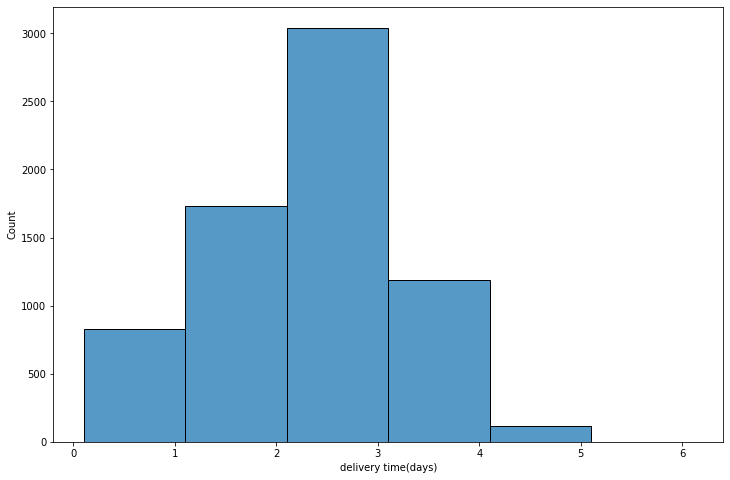

In [146]:
plt.figure(figsize=(12,8))
sns.histplot(data=deliveries, x='diff_date', binwidth=1)
plt.xlabel("delivery time(days)")
plt.show()

In [147]:
sessions = sessions[sessions['event_type'] == 'BUY_PRODUCT']

In [148]:
deliveries['month'] = deliveries['delivery_timestamp'].apply(lambda x: x.month)

#BRAK MIESIĘCY DLA LISTOPADA I GRUDNIA

In [149]:
deliveries['month'].describe()

count    6901.000000
mean        5.544269
std         2.849453
min         1.000000
25%         3.000000
50%         6.000000
75%         8.000000
max        10.000000
Name: month, dtype: float64

In [150]:
ls=['monday', 'tuesday','wednesday', 'thursday', 'friday', 'saturday', 'sunday']

In [151]:
all_info = deliveries.merge(sessions.merge(products, on='product_id', how='left'), on='purchase_id', how='left')
all_info = all_info.merge(users, on='user_id', how='left')
all_info['weekday'] = all_info['delivery_timestamp'].apply(lambda x: ls[x.weekday()])


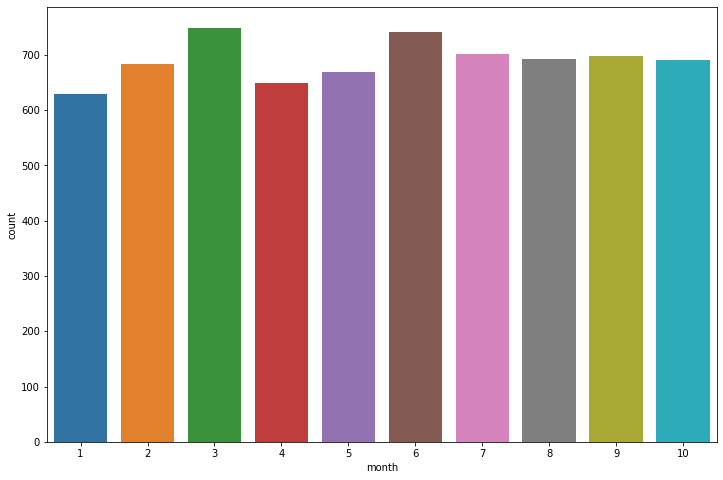

In [152]:
plt.figure(figsize=(12,8))
sns.countplot(data=all_info, x='month')
plt.show()

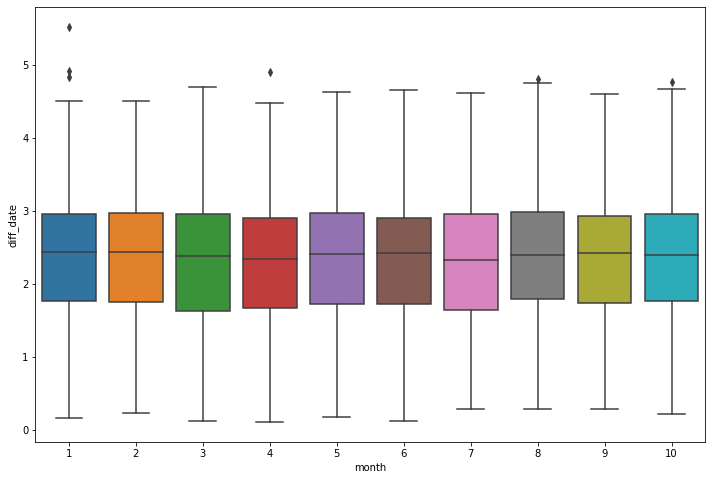

In [153]:
plt.figure(figsize=(12,8))
sns.boxplot(data=all_info, x='month', y='diff_date')
plt.show()

Okazuje się, że w danych brakuje dwóch miesięcy, jest to dość duży problem, ponieważ brakującymi miesiącami jest listopad i grudzień. Miesiące te są szczególnie problematyczne z powodu możliwych zmian czasu dostawy spowodowanych wzmożonym ruchem na czas świąt Bożego Narodzenia.

Wyłączając te dwa brakujące miesiące możemy stwierdzić, że miesiąc w którym zamawiamy nie powinien mieć szczególnego znaczenia dla czasu dostawy.

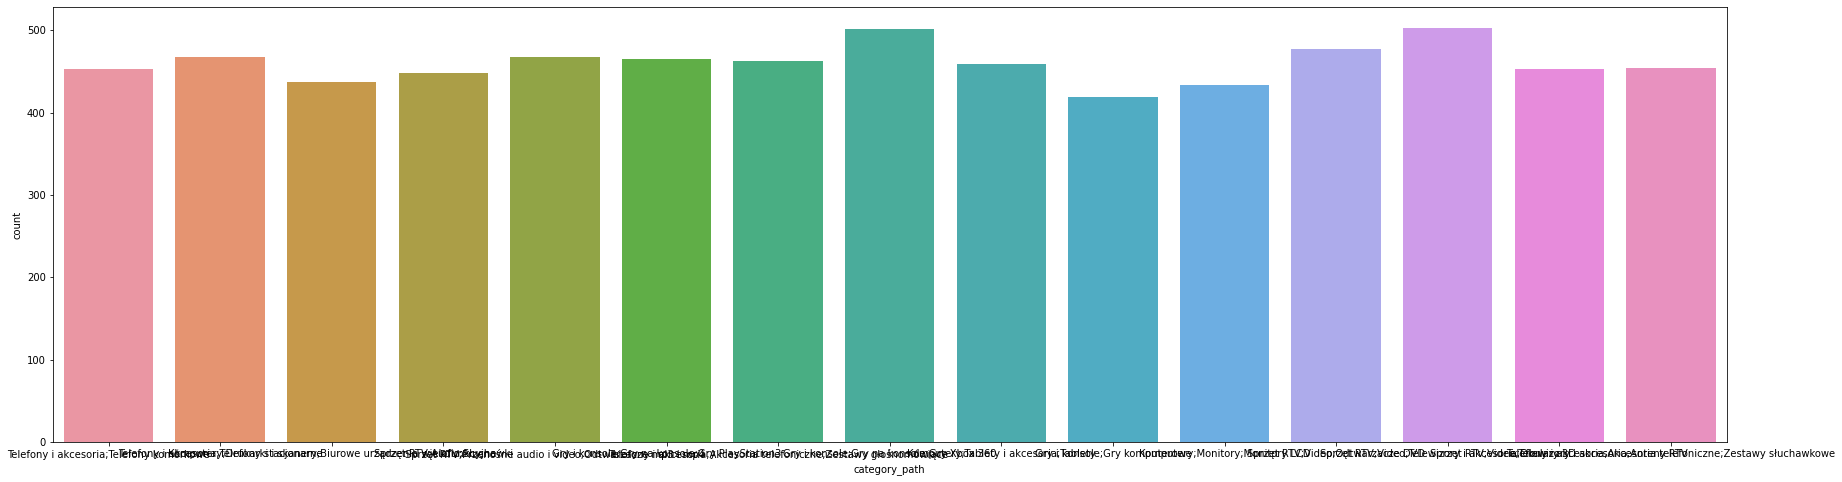

In [154]:
plt.figure(figsize=(30,8))
sns.countplot(data=all_info, x='category_path')
plt.show()

Nie ma tutaj wyraźnej nadreprezentacji któregokolwiek z typów zamówień.

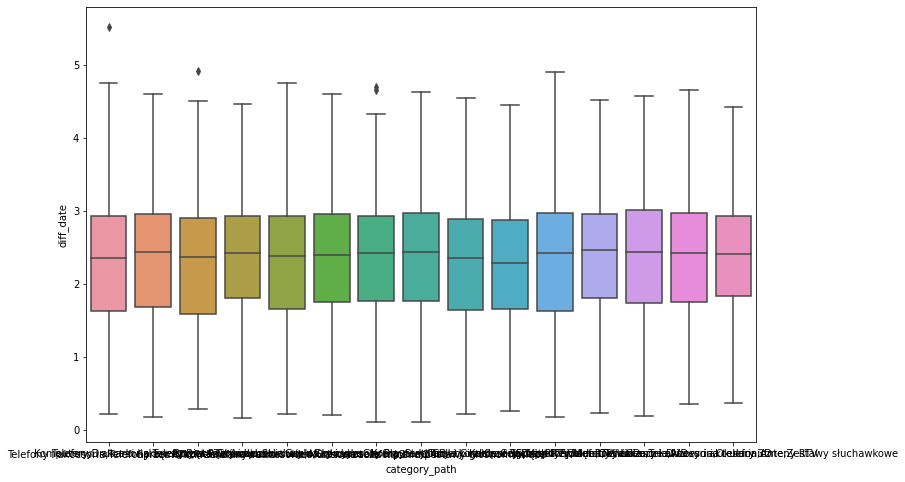

In [155]:
plt.figure(figsize=(12,8))
sns.boxplot(data=all_info, x='category_path', y='diff_date')
plt.show()

Żaden typ przesyłek nie wiąże się ze szczególnie wydłużonym czasem dostawy (chociażby ze względu na średni gabaryt paczki).

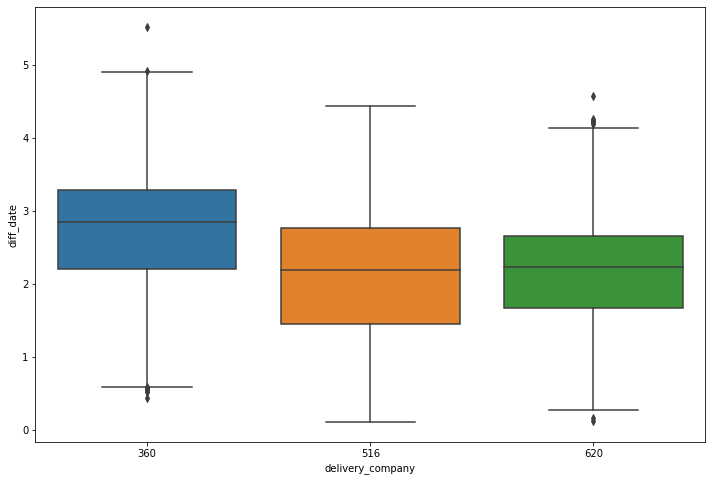

In [156]:
plt.figure(figsize=(12,8))
sns.boxplot(data=all_info, x='delivery_company', y='diff_date')
plt.show()

Wybór firmy kurierskiej jest nie bez znaczenia przy zamówieniu, pierwsza firma wyraźnie wyróżnia się na niekorzyść.

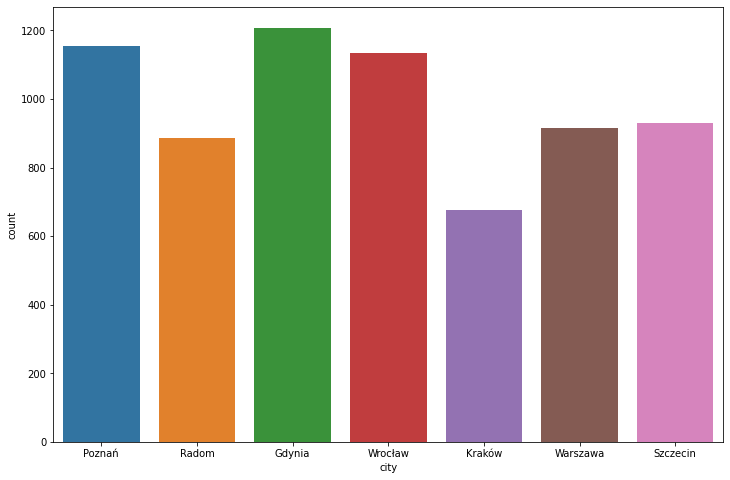

In [157]:
plt.figure(figsize=(12,8))
sns.countplot(data=all_info, x='city')
plt.show()

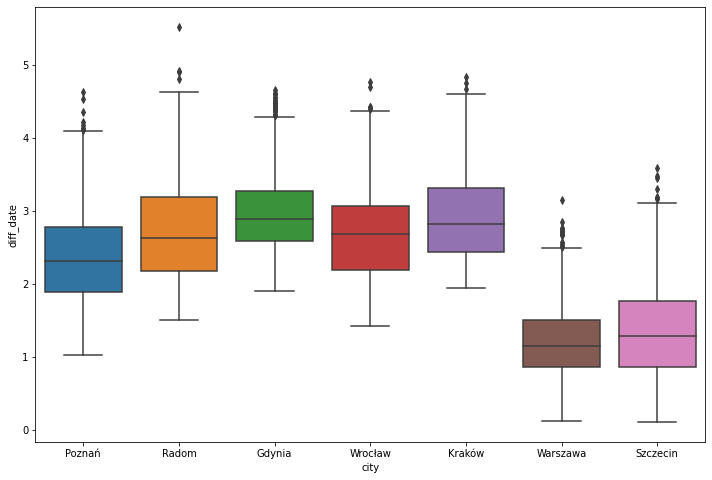

In [158]:
plt.figure(figsize=(12,8))
sns.boxplot(data=all_info, x='city', y='diff_date')
plt.show()

Powyższy wykres pokazuje, że ś©ędni czas dostawy może zależeć od miasta do którego jest skierowana przesyłka. Z tego powodu mieszkańcy Warszawy i Szczecina muszą oczekiwać 2 razy krócej na dostawę.

Niestety, dane te nie są zbyt uniwersalne, ponieważ mamy tutaj wyszczególnione tylko kilka miast. W danych brakuje części dużych miast oraz mniejszych ośrodków takich jak chociażby wsie. Poza tym nie możemy nawet pozwolić sobie na założenie, że wymienione miasta reprezentują województwwa, ponieważ jest ich mniej niż województw.

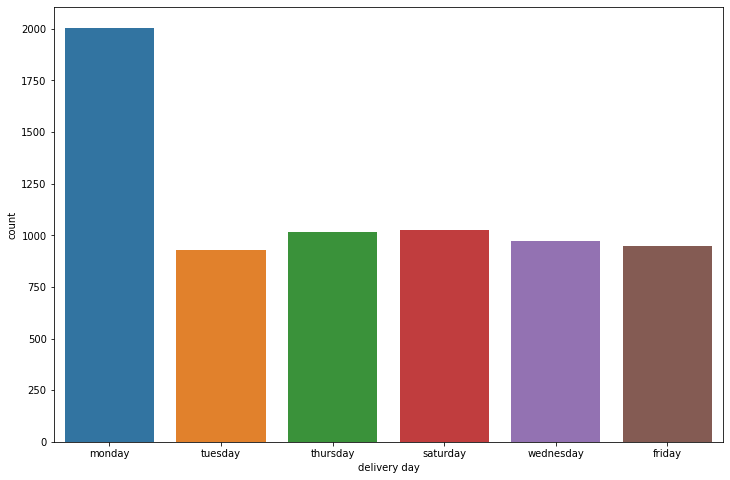

In [167]:
plt.figure(figsize=(12,8))
sns.countplot(data=all_info, x='weekday')
plt.xlabel("delivery day")
plt.show()

Z danych wynika, że dostawy nie są realizowane w weekend, powoduje to sewgo rodzaju "nawarstwienie się" dostaw w poniedziałki.

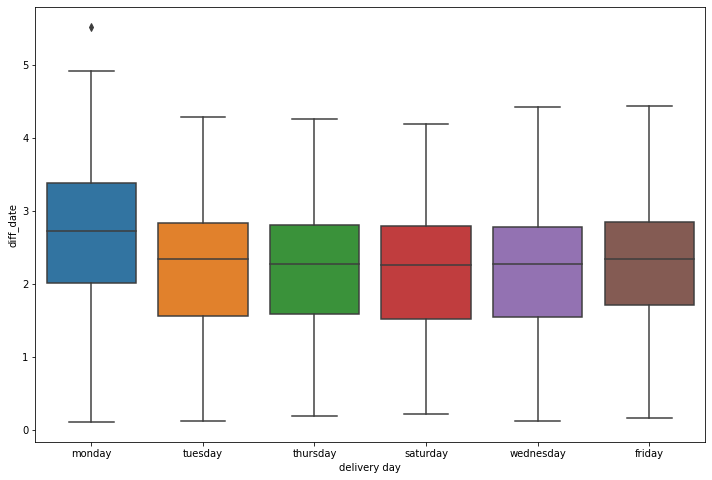

In [168]:
plt.figure(figsize=(12,8))
sns.boxplot(data=all_info, x='weekday', y='diff_date')
plt.xlabel("delivery day")
plt.show()

Powoduje to także wzrost średniego czasu oczekiwania na przesyłkę dla dostaw zrealizowanych w poniedziałki.

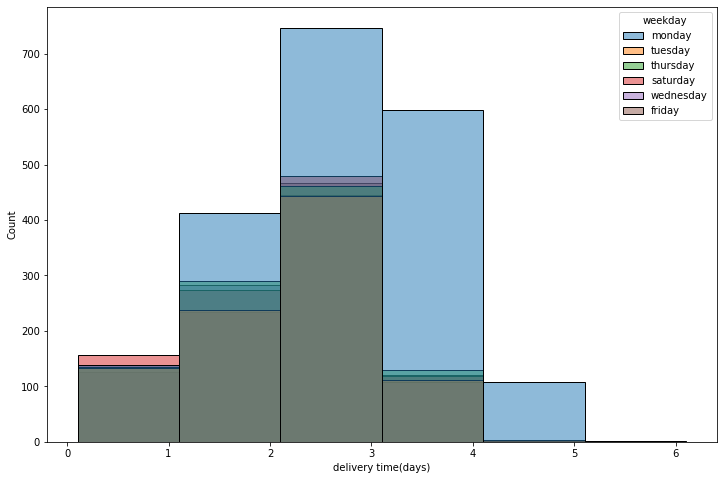

In [161]:
plt.figure(figsize=(12,8))
sns.histplot(data=all_info, x='diff_date',binwidth=1, hue='weekday')
plt.xlabel("delivery time(days)")
plt.show()

Czas oczekiwania na dostawy ma rozkąłd zbliżony do naturalnego, znowu widać tu wyraźną przewagę poniedziałków pośród dni charakteryzujących się najdłuższym czasem oczekiwania.

In [162]:
all_info['purchase_hour'] = all_info['purchase_timestamp'].apply(lambda x: x.hour)

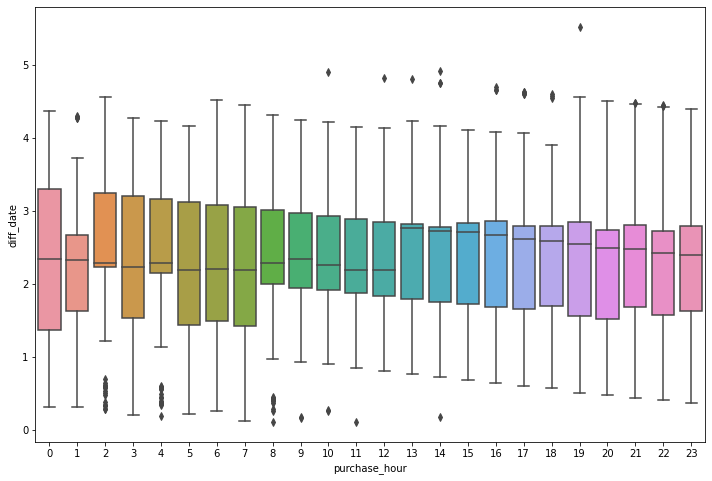

In [163]:
plt.figure(figsize=(12,8))
sns.boxplot(data=all_info, x='purchase_hour', y='diff_date')
plt.show()

W modelu trzeba będzie uwzględniać także godzinę składania zamówienia, ponieważ zamówienia składane po 13-stej często są dostarczane później od tych porannych.